# 5. Results Analysis
*Note: If you are prompted to select a kernel, please select PyTorch 1.8 Python 3.6*

In this notebook we will analyze the results from the model we trained.

You can select Run->Run All Cells from the menu to run all cells in Studio (or Cell->Run All in a SageMaker Notebook Instance).

This solution relies on a config file to run the provisioned AWS resources. Run the cell below to generate that file.

In [8]:
import boto3
import os
import json

client = boto3.client('servicecatalog')
cwd = os.getcwd().split('/')
i= cwd.index('S3Downloads')
pp_name = cwd[i + 1]
pp = client.describe_provisioned_product(Name=pp_name)
record_id = pp['ProvisionedProductDetail']['LastSuccessfulProvisioningRecordId']
record = client.describe_record(Id=record_id)

keys = [ x['OutputKey'] for x in record['RecordOutputs'] if 'OutputKey' and 'OutputValue' in x]
values = [ x['OutputValue'] for x in record['RecordOutputs'] if 'OutputKey' and 'OutputValue' in x]
stack_output = dict(zip(keys, values))

with open(f'/root/S3Downloads/{pp_name}/stack_outputs.json', 'w') as f:
    json.dump(stack_output, f)

In [9]:
import json
import os
import boto3
import matplotlib.pyplot as plt
import sagemaker
import numpy as np

from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.pytorch import PyTorchModel
from source.visualization.model_visualisation_utils import get_dfs_from_hpt, plot_df_list, get_best_training_job

with open("stack_outputs.json") as f:
    sagemaker_configs = json.load(f)

## Get data from Hyperparameter Tuning job
Enter your HPO job name to visualize the data

In [10]:
def get_latest_hpo_job(name_contains):
    sagemaker_client = boto3.client('sagemaker')
    response = sagemaker_client.list_hyper_parameter_tuning_jobs(
        SortBy='CreationTime',
        NameContains=name_contains,
        StatusEquals='Completed'
    )
    training_jobs = response['HyperParameterTuningJobSummaries']
    assert len(training_jobs) > 0, \
        'Hyperparameter tuning job has not yet completed. To view its progress open https://console.aws.amazon.com/sagemaker/ and select \
         Hyperparameter tuning jobs. Job name should contain {}.'.format(name_contains)
    latest_training_job = training_jobs[0]    
    return latest_training_job['HyperParameterTuningJobName']

In [11]:
hpo_job_name = get_latest_hpo_job(name_contains="sagemaker-soln-fpm")
hpt = HyperparameterTuningJobAnalytics(hpo_job_name)

In [12]:
summaries = hpt.training_job_summaries()
dfs = get_dfs_from_hpt(summaries, metrics=["Epoch", "train_auc", "train_acc", "train_loss",
                                           "test_auc", "test_acc", "test_loss"])

## Visualize metrics of all the jobs

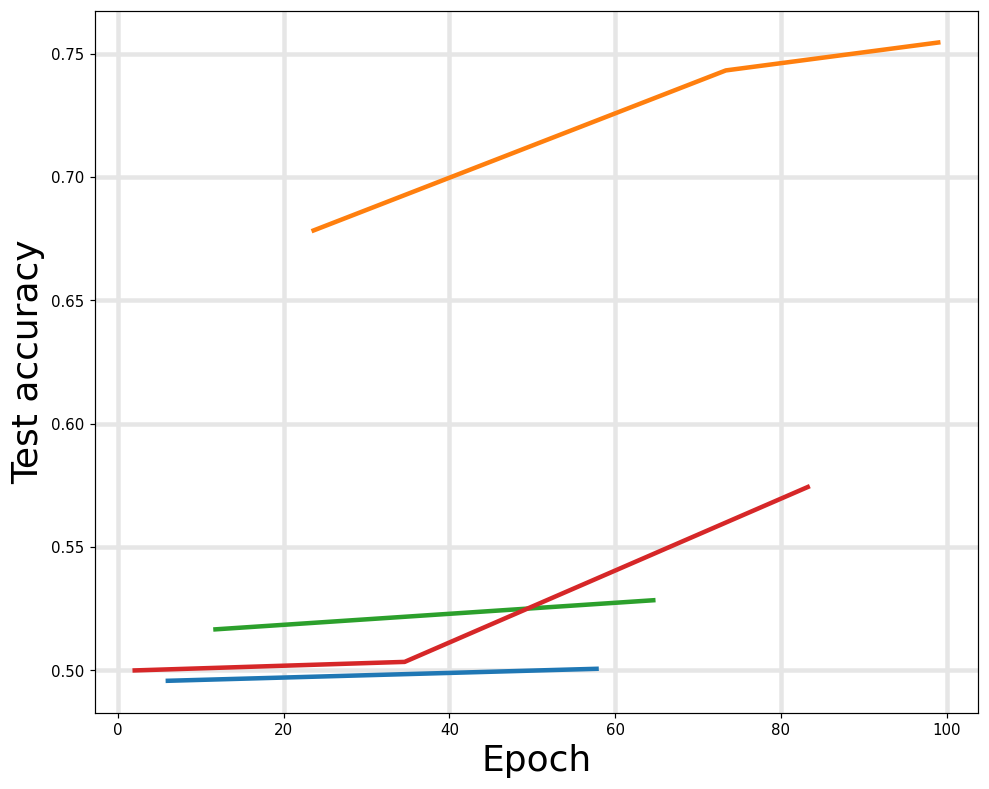

In [13]:
plot_df_list(dfs, metric_name="test_acc", y_label="Test accuracy", min_final_value=0.10)

## Visualize data from the best Training job

In [14]:
best_job_name, best_job_df = get_best_training_job(dfs, "test_auc", "maximize")
best_job_df.head()

,Epoch,timestamp,train_auc,train_acc,train_loss,test_auc,test_acc,test_loss
0,2.000000,0.0,0.523500,0.500300,0.693400,0.524300,0.500000,0.693400
1,34.583333,1.0,0.556867,0.521858,0.686833,0.535475,0.503458,0.688242
2,83.250000,2.0,0.587925,0.581762,0.667013,0.590238,0.574337,0.671237


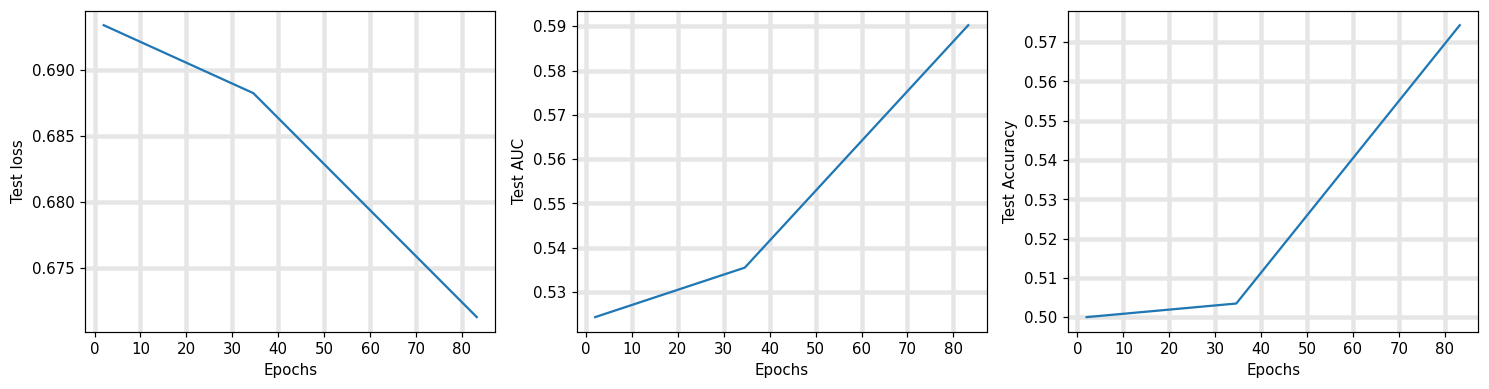

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(1500/108, 400/108), dpi=108)

axs[0].plot(best_job_df["Epoch"], best_job_df["test_loss"], label=best_job_name)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Test loss")
axs[0].grid(color="0.9", linestyle='-', linewidth=3)

axs[1].plot(best_job_df["Epoch"], best_job_df["test_auc"], label=best_job_name)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Test AUC")
axs[1].grid(color="0.9", linestyle='-', linewidth=3)

axs[2].plot(best_job_df["Epoch"], best_job_df["test_acc"], label=best_job_name)
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Test Accuracy")
axs[2].grid(color="0.9", linestyle='-', linewidth=3)

plt.tight_layout()
plt.show()

## Build endpoint for the best training job

In [16]:
s3_bucket = sagemaker_configs["S3Bucket"]  

In [17]:
sage_session = sagemaker.session.Session()
model_artifact = sage_session.describe_training_job(best_job_name)["ModelArtifacts"]["S3ModelArtifacts"]
model_artifact = os.path.join(os.path.dirname(model_artifact), "output.tar.gz")
print("Building endpoint with model {}".format(model_artifact))

Building endpoint with model s3://sagemaker-soln-fpm-js-k96rp4-sagemaker-soln-fpm/sagemaker-soln-fpm-221005-1727-001-ee6c6bb6/output/output.tar.gz


In [18]:
%%time

role = sagemaker.get_execution_role()

model = PyTorchModel(model_data=model_artifact,
                     role=role,
                     entry_point="inference.py",
                     source_dir="source/dl_utils",
                     framework_version='1.5.0',
                     py_version = 'py3',
                     name=sagemaker_configs["SageMakerModelName"],
                     code_location="s3://{}/endpoint".format(s3_bucket)
                    )

endpoint_instance_type = sagemaker_configs["SageMakerInferenceInstanceType"]

predictor = model.deploy(initial_instance_count=1, instance_type=endpoint_instance_type, endpoint_name=sagemaker_configs["SageMakerEndpointName"])

def custom_np_serializer(data):
    return json.dumps(data.tolist())
    
def custom_np_deserializer(np_bytes, content_type='application/x-npy'):
    out = np.array(json.loads(np_bytes.read()))
    return out

predictor.serializer = custom_np_serializer
predictor.deserializer = custom_np_deserializer

-----!CPU times: user 243 ms, sys: 5.42 ms, total: 248 ms
Wall time: 2min 31s


## Test the predictor

In [19]:
import botocore

config = botocore.config.Config(read_timeout=200)
runtime = boto3.client('runtime.sagemaker', config=config)

data = np.ones(shape=(1, 20, 2)).tolist()
payload = json.dumps(data)

response = runtime.invoke_endpoint(EndpointName=sagemaker_configs["SageMakerEndpointName"],
                                   ContentType='application/json',
                                   Body=payload)
out = json.loads(response['Body'].read().decode())[0]

print("Given the sample input data, the predicted probability of failure is {:0.2f}%".format(100*(1.0-out[0]))) 

Given the sample input data, the predicted probability of failure is 46.92%


## Conclusion

Our solution is easily customizable. You can customize the:

* Input data visualizations.
  * See [`sagemaker/3_data_visualization.ipynb`](sagemaker/3_data_visualization.ipynb).
* Machine learning.
  * See [`sagemaker/source/train.py`](sagemaker/source/train.py).
  * See [`sagemaker/source/dl_utils/network.py`](sagemaker/source/dl_utils/network.py).
* Dataset processing.
  * See [`sagemaker/1_introduction.ipynb`](sagemaker/1_introduction.ipynb) on how to define the config file.

Additionally, you can change configuration in the config file located [here](./config/config.yaml).
The default configuration is as follows:

* `fleet_info_fn=data/example_fleet_info.csv`
* `fleet_sensor_logs_fn=data/example_fleet_sensor_logs.csv`
* `vehicle_id_column=vehicle_id`
* `timestamp_column=timestamp`
* `target_column=target`
* `period_ms=30000`
* `dataset_size=10000`
* `window_length=20`
* `chunksize=10000`
* `processing_chunksize=1000`
* `fleet_dataset_fn=data/processed/fleet_dataset.csv`
* `train_dataset_fn=data/processed/train_dataset.csv`
* `test_dataset_fn=data/processed/test_dataset.csv`
* `period_column=period_ms`

`fleet_info_fn`, `fleet_sensor_logs_fn`, `fleet_dataset_fn`, `train_dataset_fn`, `test_dataset_fn` defines the location of dataset files.

`vehicle_id_column`, `timestamp_column`, `target_column`, and `period_column` defines the headers for columns

`dataset_size`, `chunksize`, `processing_chunksize`, `period_ms`, and `window_length` defines properties of the dataset.